# Verify Support Points Implementation

*Zachary del Rosario*, 2021-01-05

This notebook verifies the implementation of `gr.tran_sp()`. This routine is based on the `sp.ccp` algorithm of Mak and Joseph (2018). This verification study includes both a visual check and a formal convergence study.


In [1]:
import grama as gr
import numpy as np
import pandas as pd
import time

from datetime import datetime
from plotnine import *

DF = gr.Intention()

In [2]:
print("Last executed: {}".format(datetime.now(tz=None)))

Last executed: 2021-01-26 10:27:56.740629


## Visual Inspection

---

The following section is an "eyeball norm" check of the `gr.tran_sp()` implementation. A compacted dataset should appear representative of the original dataset.

Set up model:


In [3]:
## Correlated gaussian
md = (
    gr.Model()
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="norm", loc=0, scale=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(var1="x", var2="y", corr=0.5)
    )
)

md.printpretty()

model: None

  inputs:
    var_det:
    var_rand:
      x: (+0) norm, {'loc': 0, 'scale': 1}
      y: (+0) norm, {'loc': 0, 'scale': 1}
    copula:
        Gaussian copula with correlations:
  var1 var2  corr
0    x    y   0.5
  functions:


Generate a dataset to compact:


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


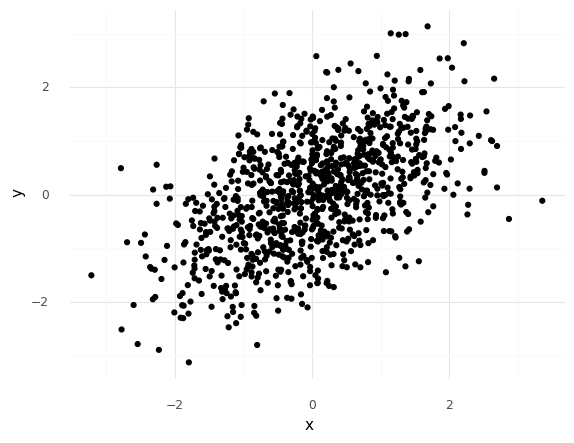

<ggplot: (8738300168361)>

In [4]:
df_data = gr.eval_monte_carlo(
    md,
    n=1e3,
    skip=True,
)

(
    df_data
    >> ggplot(aes("x", "y"))
    + geom_point()
    + theme_minimal()
)

Run the support points algorithm; visually compare the compacted dataset against the original.


tran_sp has selected var = ['x', 'y']
tran_sp finished in 89 iterations with distance criterion 9.975e-04


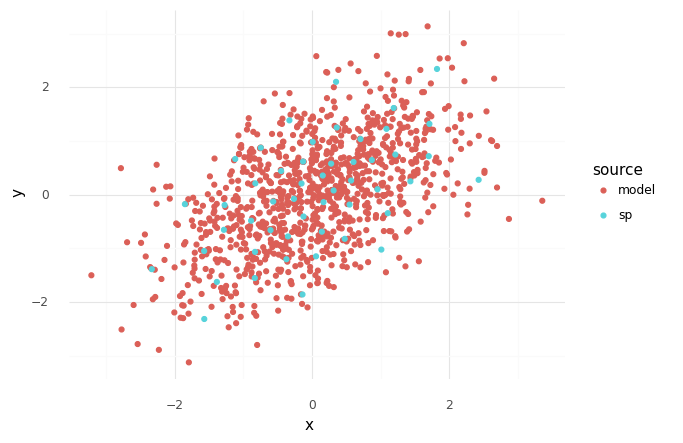

<ggplot: (8738200768721)>

In [5]:
df_sp = (
    df_data
    >> gr.tf_sp(
        n=50,
        seed=102,
        tol=1e-3,
        n_maxiter=int(1e3),
    )
)

(
    df_data
    >> gr.tf_mutate(source="model")
    >> gr.tf_bind_rows(
        df_sp
        >> gr.tf_mutate(source="sp")
    )
    >> ggplot(aes("x", "y", color="source"))
    + geom_point()
    
    + theme_minimal()
)

This passes the "eyeball norm" for me; the support points (`sp`) appear to be representative of the original dataset.


Visualize the change from initial guess to support points.


tran_sp has selected var = ['x', 'y']
tran_sp finished in 0 iterations with distance criterion 2.000e-03


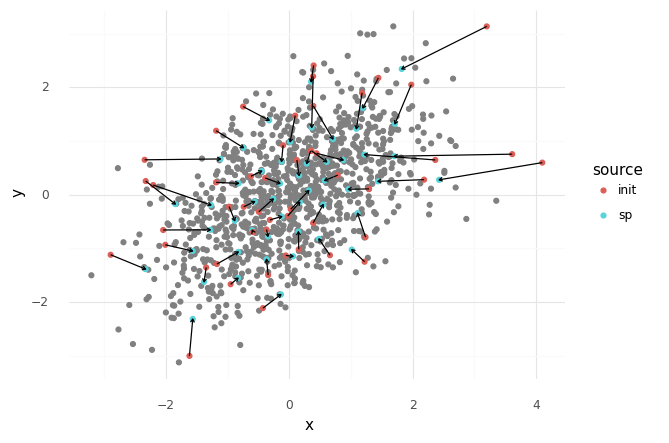

<ggplot: (8738199165969)>

In [6]:
df_sp0 = (
    df_data
    >> gr.tf_sp(
        n=50,
        seed=102,
        n_maxiter=0, # Halt at initial guess
    )
)

df_both = (
    df_sp
    >> gr.tf_bind_cols(
        df_sp0
        >> gr.tf_rename(x0=DF.x, y0=DF.y)
    )
)

(
    df_sp
    >> gr.tf_mutate(source="sp")
    >> gr.tf_bind_rows(
        df_sp0
        >> gr.tf_mutate(source="init")
    )
    >> ggplot(aes("x", "y"))
    + geom_point(
        data=df_data,
        color="grey",
    )
    + geom_point(aes(color="source"))
    + geom_segment(
        data=df_both,
        mapping=aes(x="x0", xend="x", y="y0", yend="y"),
        arrow=arrow(length=0.05)
    )
    
    + theme_minimal()
)

*Observations*:

- Generally, points in the more-dense region of the distribution tend to move less, while those in the less-dense tend to move further.
- Generally, points are moving "up" the density, towards its center.


Formally, the `sp.ccp` algorithm minimizes a Monte Carlo approximation of the energy distance. Could we assess convergence by inspecting the gradient of this quantity?

Set up the $\hat{E}$ objective; Equation (MC) from Mak and Joseph (2018).


In [7]:
Y = df_data.values

def obj(X):
    # Setup
    n = X.shape[0]
    N = Y.shape[0]
    
    t1 = 0
    t2 = 0
    
    for i in range(n):
        t1 = t1 + np.sum(np.linalg.norm(Y - X[i], axis=1))
        t2 = t2 + np.sum(np.linalg.norm(X - X[i], axis=1))
        
    return (2 / n / N) * t1 + t2 / n**2

def obj_v(v):
    p = Y.shape[1]
    X_tmp = v.reshape((-1, p))
    return obj(X_tmp)

# Compute objective at start and end
X0_v = df_sp0.values.flatten()
f0 = obj_v(X0_v)
Xs_v = df_sp.values.flatten()
fs = obj_v(Xs_v)

print(f0)
print(fs)

6.63180850800797
5.345617351716227


Approximate the gradient of the objective with a central difference. 


In [8]:
# Stepsize
h = 1e-8

## Central difference
def grad(v0, fun, h=1e-6):
    n_v = len(v0)
    grad = np.zeros(n_v)
    for i in range(n_v):
        e_v = np.zeros(n_v)
        e_v[i] = 0.5 * h
        
        fs_m = fun(v0 - e_v)
        fs_p = fun(v0 + e_v)
        
        grad[i] = (fs_p - fs_m) / h
    return grad

G0 = grad(X0_v, obj_v)
Gs = grad(Xs_v, obj_v)


Compare the gradient at the start and end.


In [9]:
print(np.linalg.norm(G0))
print(np.linalg.norm(Gs))


0.3818755604577567
0.3567504242697538


The gradient of the objective does not seem to be a promising way to quantitatively assess convergence.


### A note on strong anisotropy

The support points algorithm seems to have trouble with strongly anisotropic data. For example, let's apply the algorithm to the cantilever beam's random variable input space:

In [10]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()

df_beam = gr.eval_monte_carlo(
    md_beam, 
    n=1e3, 
    df_det="nom", 
    skip=True, 
    seed=101
)

df_beam_sp_no = (
    df_beam
    >> gr.tf_sp(
        n=50, 
        var=["H", "V", "E", "Y"], 
        # *Disable* the standardization for demonstration
        standardize=False, 
        n_maxiter=1000,
        seed=101,
    )
)

df_both = (
    df_beam
    >> gr.tf_select(["H", "V", "E", "Y"])
    >> gr.tf_mutate(source="Original")
    >> gr.tf_bind_rows(
        df_beam_sp_no
        >> gr.tf_mutate(source="SP")
    )
)


eval_monte_carlo() is rounding n...
Estimated runtime for design with model (Cantilever Beam):
  0.00503 sec
tran_sp finished in 1000 iterations with distance criterion 5.419e-01


Note that the distance criterion is not met even after `1000` iterations. If we inspect the (unconverged) points, we can see they are "compressed" along the lower-scale directions:


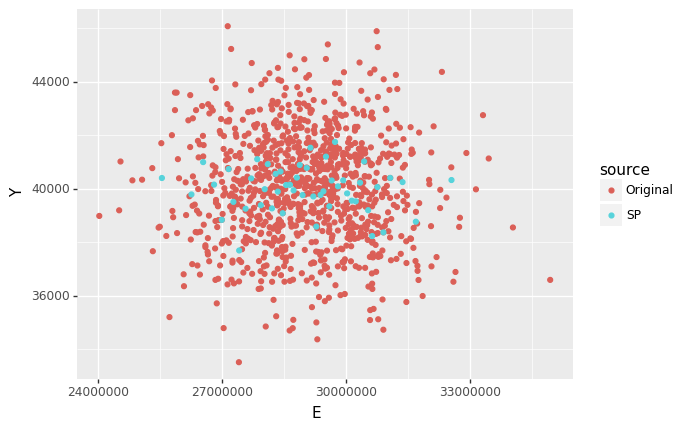

<ggplot: (8738199163213)>

In [11]:
(
    df_both
    >> ggplot(aes("E", "Y", color="source"))
    + geom_point()
)

To solve this problem, the implementation of `tran_sp()` by default *standardizes* each column before applying the support points algorithm, and restores the scale before returning the results. This solve the issue shown above:


tran_sp finished in 290 iterations with distance criterion 9.978e-04


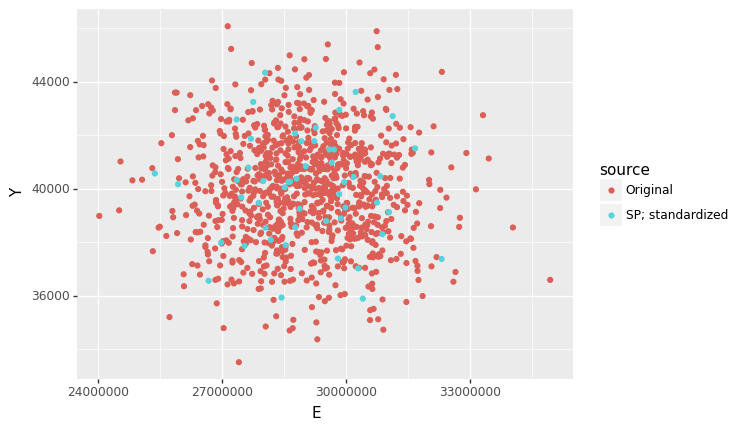

<ggplot: (8738217429121)>

In [12]:
df_beam_sp_std = (
    df_beam
    >> gr.tf_sp(
        n=50, 
        var=["H", "V", "E", "Y"], 
        standardize=True, 
#         n_maxiter=1000,
        seed=101,
    )
)

df_both_std = (
    df_beam
    >> gr.tf_select(["H", "V", "E", "Y"])
    >> gr.tf_mutate(source="Original")
    >> gr.tf_bind_rows(
        df_beam_sp_std
        >> gr.tf_mutate(source="SP; standardized")
    )
)

(
    df_both_std
    >> ggplot(aes("E", "Y", color="source"))
    + geom_point()
)

With standardization, the sp algorithm converges properly with the default settings, and properly represents the scale of all the variable considered here.


## Formal Convergence Study

---

Perform a formal convergence study to numerically assess the accuracy of the `tran_sp()` routine. Use an integration problem with known expectation.

Implement the [Bratley](https://www.sfu.ca/~ssurjano/bratleyetal92.html) model:


In [13]:
## Bratley model at various dimensionalities
md_br1 = (
    gr.Model("Bratley, 1d")
    >> gr.cp_function(
        fun=lambda x: -x[0],
        var=1,
        out=["f"],
    )
    >> gr.cp_marginals(
        x0=dict(dist="uniform", loc=0, scale=1),
    )
    >> gr.cp_copula_independence()
)

md_br2 = (
    gr.Model("Bratley, 2d")
    >> gr.cp_function(
        fun=lambda x: -x[0] + x[0] * x[1],
        var=2,
        out=["f"],
    )
    >> gr.cp_marginals(
        x0=dict(dist="uniform", loc=0, scale=1),
        x1=dict(dist="uniform", loc=0, scale=1),
    )
    >> gr.cp_copula_independence()
)

md_br3 = (
    gr.Model("Bratley, 3d")
    >> gr.cp_function(
        fun=lambda x: -x[0] + x[0] * x[1] - x[0] * x[1] * x[2],
        var=3,
        out=["f"],
    )
    >> gr.cp_marginals(
        x0=dict(dist="uniform", loc=0, scale=1),
        x1=dict(dist="uniform", loc=0, scale=1),
        x2=dict(dist="uniform", loc=0, scale=1),
    )
    >> gr.cp_copula_independence()
)

## Exact expectation
def br_exact(d):
    return -(1 - (-0.5)**d) / 3

md_br3.printpretty()


model: Bratley, 3d

  inputs:
    var_det:
    var_rand:
      x0: (+0) uniform, {'loc': 0, 'scale': 1}
      x1: (+0) uniform, {'loc': 0, 'scale': 1}
      x2: (+0) uniform, {'loc': 0, 'scale': 1}
    copula:
        Independence copula
  functions:
    f0: ['x0', 'x1', 'x2'] -> ['f']


Overkill sampling, to check implementation against analytic expression and for support point algorithm:


In [14]:
df_br3 = (
    md_br3
    >> gr.ev_monte_carlo(df_det="nom", n=1e4, seed=101)
)

Ehat3 = (
    df_br3
    >> gr.tf_summarize(E=gr.mean(DF.f))
).E[0]
E3 = br_exact(3)
err3 = np.abs((Ehat3 - E3) / E3)

print("Relative error = {0:4.3e}".format(err3))


eval_monte_carlo() is rounding n...
Relative error = 2.464e-03


We should not expect the support point approach to reach a relative error smaller than this observed error; the `sp.ccp` algorithm is limited by the Monte Carlo approximation of the energy distance. The `sp.sccp` algorithm should be able to overcome this limitation, but I have not yet implemented this.

Perform a convergence study with support points and simple Monte Carlo.


In [15]:
# Select sample sizes
N_all = [3, 4, 5, 6, 7, 8, 9, 10, 30, 50]
n_repl = 40

# Setup
Er_sp = np.zeros((len(N_all), n_repl))
Er_mc = np.zeros((len(N_all), n_repl))
SE_mc = np.zeros((len(N_all), n_repl))
# Exact solution
E3 = br_exact(3)

seed0 = 101
df_convergence = pd.DataFrame()
t0 = time.time()
for i, n in enumerate(N_all):
    for j in range(n_repl):
        seed = seed0 + j
        ## Simple Monte Carlo
        df_mc_tmp = (
            md_br3
            >> gr.ev_monte_carlo(df_det="nom", n=n, seed=seed)
            >> gr.tf_summarize(
                E=gr.mean(DF.f),
                se=gr.sd(DF.f) / np.sqrt(n)
            )
        )
        Ehat_mc = df_mc_tmp.E[0]
        Er_mc[i, j] = np.abs((Ehat_mc - E3) / E3)
        # Store SE for MC as well
        SE_mc[i, j] = np.abs(df_mc_tmp.se[0] / E3)
    
        ## Support Points
        df_sp_tmp = gr.tran_sp(
            df_br3[["x0", "x1", "x2"]], 
            n=n, 
            seed=seed,
            verbose=False,
        )
        df_sp_br3 = (
            md_br3
            >> gr.ev_df(df=df_sp_tmp)
        )
        Ehat_sp = (
            df_sp_br3
            >> gr.tf_summarize(E=gr.mean(DF.f))
        ).E[0]
        Er_sp[i, j] = np.abs((Ehat_sp - E3) / E3)
    
    df_tmp = gr.df_make(
        Er_mc=Er_mc[i],
        SE_mc=SE_mc[i],
        Er_sp=Er_sp[i],
        repl=list(range(n_repl)),
        N=n,
    )
    df_convergence = pd.concat((df_convergence, df_tmp), axis=0)
t1 = time.time()
print("Execution time: {0:4.3e} min".format((t1 - t0) / 60))


Execution time: 6.826e+00 min


Visually compare the convergence histories:


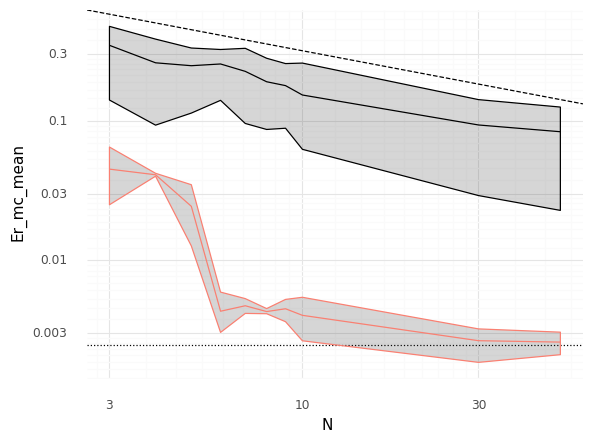

<ggplot: (8738238101181)>

In [16]:
(
    df_convergence
    >> gr.tf_group_by(DF.N)
    >> gr.tf_summarize(
        Er_mc_mean=gr.mean(DF.Er_mc),
        Er_mc_lo=gr.quant(DF.Er_mc, p=0.25),
        Er_mc_hi=gr.quant(DF.Er_mc, p=0.75),
        
        Er_sp_mean=gr.mean(DF.Er_sp),
        Er_sp_lo=gr.quant(DF.Er_sp, p=0.25),
        Er_sp_hi=gr.quant(DF.Er_sp, p=0.75),
    )
    
    >> ggplot(aes(x="N"))
    + geom_hline(yintercept=err3, color="black", linetype="dotted")
    + geom_ribbon(
        mapping=aes(ymin="Er_mc_lo", ymax="Er_mc_hi"),
        color="black",
        alpha=1 / 5
    )
    + geom_ribbon(
        mapping=aes(ymin="Er_sp_lo", ymax="Er_sp_hi"),
        color="salmon",
        alpha=1 / 5
    )
    
    + geom_line(aes(y="Er_mc_mean"), color="black")
    + geom_line(aes(y="Er_sp_mean"), color="salmon")
    + geom_abline(intercept=0, slope=-1/2, linetype="dashed")
    
    + scale_x_log10()
    + scale_y_log10()
    + theme_minimal()
)

*Observations*:

- Simple Monte Carlo (in black) exhibits a square-root convergence (dashed line), as expected
- Support (in salmon) exhibits a rapid initial convergence at low $N$, then becomes roughly parallel to SMC. 
  - This is much like the results in Mak and Joseph (2018), Figure 4, e.g. GAPK (p = 5).
  - I suspect the mechanism is different though; they use `sp.sccp` in their results.
- As expected, the support approach does not significantly exceed the "overkill" SMC relative error (horizontal dotted line) computed above.


## References

- Mak and Joseph "Support Points" (2018) *Annals of Statistics*